In [410]:
import numpy as np
import pandas as pd 
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from scipy.stats import cumfreq
import sklearn.metrics as skm

from sklearn.calibration import CalibratedClassifierCV
import sklearn.metrics as skm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

In [3]:
import fairlearn.metrics as flm
from fairlearn.reductions import ExponentiatedGradient, GridSearch, DemographicParity, EqualizedOdds, GroupLossMoment, Moment, SquareLoss
from fairlearn.metrics import group_mean_prediction, group_mean_squared_error, group_mean_overprediction, group_roc_auc_score, group_accuracy_score
from fairlearn.metrics import group_roc_auc_score

In [133]:
from fairlearn.metrics import group_mean_underprediction

# Helper Functions 

In [4]:
def split_dataframe(split, X, y, A, frac=True):
  if frac==True: 
    random_idx = np.random.random_integers(0, len(X), int(split*len(X)))
  else:
    random_idx = np.random.random_integers(0, len(X), split)
  X_random = X.iloc[random_idx]
  y_random = y.iloc[random_idx]
  A_random = A.iloc[random_idx]

  return X_random, y_random, A_random

In [5]:
def loss_fct(i):
  return grid_search.objective_weight * grid_search._objectives[i] + \
  grid_search.constraint_weight * grid_search._gammas[i].max()

In [6]:
def group_metric_as_df(name, group_metric_result):
    a = pd.Series(group_metric_result.by_group)
    a['overall'] = group_metric_result.overall
    return pd.DataFrame({name: a})

In [7]:
def plot_data(Xs, Ys, A):
  print(Xs.shape, Ys.shape, A.shape)
  labels = np.unique(A)
  
  for l in labels:
    label_string = str(l.item())
    mask =  A== l
    plt.scatter(Xs[mask].mean(axis=1), Ys[mask], label=str("Label="+label_string))
    plt.xlabel("GPA")
    plt.ylabel("Higher or not higher than 3.0 ")
      
  plt.legend()
  plt.show()

In [8]:
def compare_cdfs(data, A, num_bins=100):
    cdfs = {}
    assert len(np.unique(A)) == 2
    
    limits = ( min(data), max(data) )
    s = 0.5 * (limits[1] - limits[0]) / (num_bins - 1)
    limits = ( limits[0]-s, limits[1] + s)
    
    for a in np.unique(A):
        subset = data[A==a]
        
        cdfs[a] = cumfreq(subset, numbins=num_bins, defaultreallimits=limits)
        
    lower_limits = [v.lowerlimit for _, v in cdfs.items()]
    bin_sizes = [v.binsize for _,v in cdfs.items()]
    actual_num_bins = [v.cumcount.size for _,v in cdfs.items()]
    
    assert len(np.unique(lower_limits)) == 1
    assert len(np.unique(bin_sizes)) == 1
    assert np.all([num_bins==v.cumcount.size for _,v in cdfs.items()])
    
    xs = lower_limits[0] + np.linspace(0, bin_sizes[0]*num_bins, num_bins)
    
    disparities = np.zeros(num_bins)
    for i in range(num_bins):
        cdf_values = np.clip([v.cumcount[i]/len(data[A==k]) for k,v in cdfs.items()],0,1)
        disparities[i] = max(cdf_values)-min(cdf_values)  
    
    return xs, cdfs, disparities
    
    
def plot_and_compare_cdfs(data, A, num_bins=100, loc='best'):
    xs, cdfs, disparities = compare_cdfs(data, A, num_bins)
    
    for k, v in cdfs.items():
        plt.plot(xs, v.cumcount/len(data[A==k]), label=k)
    
    assert disparities.argmax().size == 1
    d_idx = disparities.argmax()
    
    xs_line = [xs[d_idx],xs[d_idx]]
    counts = [v.cumcount[d_idx]/len(data[A==k]) for k, v in cdfs.items()]
    ys_line = [min(counts), max(counts)]
    
    plt.plot(xs_line, ys_line, 'o--')
    disparity_label = "max disparity = {0:.3f}\nat {1:0.3f}".format(disparities[d_idx], xs[d_idx])
    plt.text(xs[d_idx], 1, disparity_label, ha="right", va="top")
    
    plt.xlabel(data.name)
    plt.ylabel("cumulative frequency")
    plt.legend(loc=loc)
    plt.show()

In [9]:
# show_proportions is only a helper function for plotting
def show_proportions(X, sensitive_features, y_pred, y=None, description=None, plot_row_index=1):
    print("\n" + description)
    plt.figure(plot_row_index)
    plt.title(description)
    plt.ylabel("P[3.0 GPA predicted | gender]")
    
    indices = {}
    positive_indices = {}
    negative_indices = {}
    recidivism_count = {}
    recidivism_pct = {}
    groups = np.unique(sensitive_features.values)
    n_groups = len(groups)
    color = plt.cm.rainbow(np.linspace(0,1,n_groups))
    x_tick_labels_basic = []
    x_tick_labels_by_label = []
    for index, group in enumerate(groups):
        indices[group] = sensitive_features.index[sensitive_features == group]
        recidivism_count[group] = sum(y_pred[indices[group]])
        recidivism_pct[group] = recidivism_count[group]/len(indices[group])    
        plt.bar(index + 1, recidivism_pct[group], color=color[index])
        x_tick_labels_basic.append(group)
    
        if y is not None:
            positive_indices[group] = sensitive_features.index[(sensitive_features == group) & (y == 1)]
            negative_indices[group] = sensitive_features.index[(sensitive_features == group) & (y == 0)]
            prob_1 = sum(y_pred[positive_indices[group]])/len(positive_indices[group])
            prob_0 = sum(y_pred[negative_indices[group]])/len(negative_indices[group])

            plt.bar(n_groups + 1 + 2 * index, prob_1, color=color[index])
            plt.bar(n_groups + 2 + 2 * index, prob_0, color=color[index])
            x_tick_labels_by_label.extend(["{} GPA > 3.0 ".format(group), "{} GPA < 3.0".format(group)])
    
    x_tick_labels = x_tick_labels_basic + x_tick_labels_by_label
    plt.xticks(range(1, len(x_tick_labels)+1), x_tick_labels, rotation=45, horizontalalignment="right")

# Introduction

We consider the task of predicting student GPA during their first three semesters of university based on their entrance exams. The fairness across gender was explored in the paper ["Preventing undesirable behavior of intelligent machines" (Thomas et. al 2019) ](https://science.sciencemag.org/content/366/6468/999) We highlight some of the fairness considerations that come up in GPA prediction prediction by gender.

The [dataset](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/O35FW8#) contains the performance of 43,303 students from Brazil on their nine entrance exams for the Federal University of Rio Grande do Sul and their GPA over their first three semesters of university. Each row contains anonymized data on one student's scores on nine exams (phsics, biology, history, second language, geography, literature, Portuguese essay, math, chemistry) along with a boolean indicating their gender (0 female, 1 male). The outcome is a numerical value representing their average GPA on a 4.0 scale during the first three months of university.

# Exploratory Data Analysis 

In [10]:
names = ['gender', 'physics','biology','history','second_language',
'geography','literature','portuguese', 'math','chemistry', 'gpa']
data = pd.read_csv("data.csv", names=names)

In [11]:
all_train_grouped = data.groupby('gender')

counts_by_gender = all_train_grouped[['gpa']].count().rename(
    columns={'gpa': 'count'})

quartiles_by_gender = all_train_grouped[['gpa']].quantile([.25, .50, .75]).rename(
    index={0.25: "25%", 0.5: "50%", 0.75: "75%"}, level=1).unstack()

summary_by_gender = pd.concat([counts_by_gender, quartiles_by_gender], axis=1)

summary_by_gender.rename(index={0: "female", 1: "male"}, inplace=True)
summary_by_gender.loc['Difference']=(summary_by_gender.iloc[0]-summary_by_gender.iloc[1]).abs()
display(summary_by_gender)

,count,"(gpa, 25%)","(gpa, 50%)","(gpa, 75%)"
gender,,,,
female,20968.0,2.53333,3.11333,3.54667
male,22335.0,2.08333,2.71000,3.27667
Difference,1367.0,0.45000,0.40333,0.27000


We see there is a similar distribution between male and female students in the data (There are 6.5% more males samples than females). 

We see that the GPA of female students is higher than male across all quartiles. The difference across the GPAs is smallest in the 75th percentile (0.27 difference). However the gap is much larger in the 50th and 25th percentile.

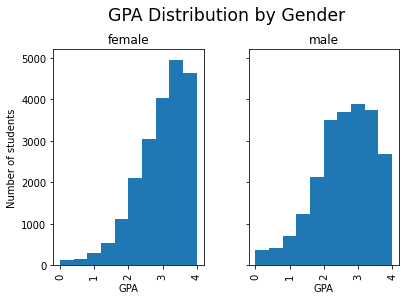

In [12]:
gender_gpa = data[["gender", "gpa"]].copy()
gender_gpa.replace({'gender': {0:"female", 1:"male"}}, inplace=True)
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
for i in range(len(axes)):
  axes[i].set(xlabel='GPA')
  if i==0:
    axes[i].set(ylabel='Number of students')
gender_gpa.hist(by='gender', column='gpa', ax = axes)
# Add title and axis names
plt.suptitle('GPA Distribution by Gender', x=0.5, y=1.05, ha='center', fontsize='xx-large')
plt.show()

We see that the distribution of GPAs for females skews much higher for females than males. Females have fewer students with lower GPAs and more students with GPAs in the 3-4 range. Male students have on average lower GPAs with an equal number of students in the 2-3.5 range. 


True Percent Difference of Female GPA over Male GPA
13.58 %


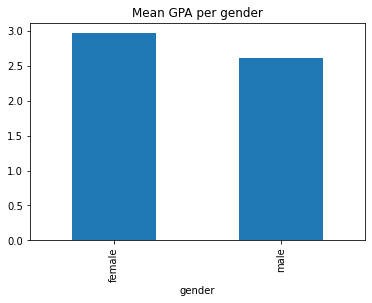

In [13]:
all_train_grouped = data.groupby('gender').mean()
all_train_grouped.rename(index={0: "female", 1: "male"}, inplace=True)
all_train_grouped.gpa.plot(kind='bar', title='Mean GPA per gender')
pct_greater = (all_train_grouped.gpa.loc['female'] - all_train_grouped.gpa.loc['male'])/ all_train_grouped.gpa.loc['male']
print('True Percent Difference of Female GPA over Male GPA')
print(round(pct_greater*100,2), '%')

We see that the Mean GPA across all samples is higher for females by 13.58%.

,physics,biology,history,second_language,geography,literature,portuguese,math,chemistry,gpa
gender,,,,,,,,,,
female,551.670616,565.289221,566.298738,571.287158,555.585070,595.972841,557.790898,550.858560,558.348288,2.968778
male,599.078144,571.824748,594.465843,576.533323,592.246688,571.406824,544.704249,605.797135,584.256591,2.613880


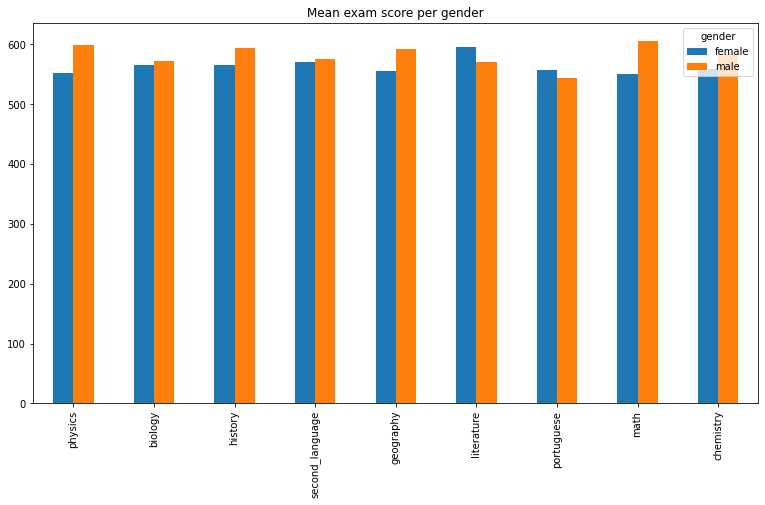

In [15]:
display(all_train_grouped)
test_scores_grouped = all_train_grouped.transpose().iloc[0:9,]
test_scores_grouped.plot(kind='bar', figsize=(13,7), title='Mean exam score per gender')

# Model Performance Comparisons for ML Algos with & without Fairness Constraints

## Mean GPA Prediction Error Comparisons 

We now explore the level of fairness of three standard ML algorithms: Least Squares, Random Forest, Multi-layer Perceptron regressors. 

For each of these, the pipeline will consist of:
- Remove the protected attribute from the predictors. This is an essential step that allows to analyze whether the algorithm has an inner bias toward a specific group, female or male in our study.
- Split the dataset in train-test in a 4:1 ratio, train the model on the train data and predict on the test data.

Specifically, we'll have the following data subgroups:

*   **X_train, X_test**: features describing the training and test data; the scores on 9 entrance exams
*   **A_train, A_test**:  gender of each student (female or male)
*   **y_train, y_test**: labels of the training and test data; the labels are numerical on the scale [0,4.0] representing the GPA during the first three months of University
*   **y_train_bool, y_test_bool**: binary labels of the training and test data; the labels are boolean; 1 if gpa > 3.0; 0 otherwise 









In [528]:
X = data.iloc[:,:-1]
y = data.gpa
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)
A_train = X_train.gender
A_test = X_test.gender
del X_train['gender']
del X_test['gender']

y_train_bool = y_train > 3.0
y_test_bool = y_test > 3.0

X_train.reset_index(inplace = True, drop = True)
y_train.reset_index(inplace = True, drop = True)
y_train_bool.reset_index(inplace = True, drop = True)
A_train.reset_index(inplace = True, drop = True)
X_test.reset_index(inplace = True, drop = True)
y_test.reset_index(inplace = True, drop = True)
A_test.reset_index(inplace = True, drop = True)
y_test_bool.reset_index(inplace = True, drop = True)

In [15]:
# Least Squares
lr = LinearRegression().fit(X_train, y_train)
lr_pred = lr.predict(X_test)

A multilayer perceptron (MLP) is a class of feedforward artificial neural network (ANN). Except for the input nodes, each node is a neuron that uses a nonlinear activation function. MLP utilizes a supervised learning technique called backpropagation for training.

In [16]:
# Multi-layer Perceptron
mlp = MLPRegressor(early_stopping=True,
                   activation="relu",
                   random_state=42).fit(X_train, y_train)    
mlp_pred = mlp.predict(X_test)

A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is always the same as the original input sample size but the samples are drawn with replacement.

In [17]:
# Random Forest
rf = RandomForestRegressor(n_estimators=10, max_depth=5).fit(X_train, y_train)
rf_pred = rf.predict(X_test)

The next step consists in analyzing whether any of these alogirthms shows a consistent bias toward one gender.

To do that, we divided the prediction output in two groups, female and male, and then computed the **mean prediction error** for each group.

- Compute error as: `y_pred - y_observed`
- Compute mean error grouped by gender

[Text(0, 0.5, 'Prediction Error'), Text(0.5, 0, 'Regression Algorithm')]

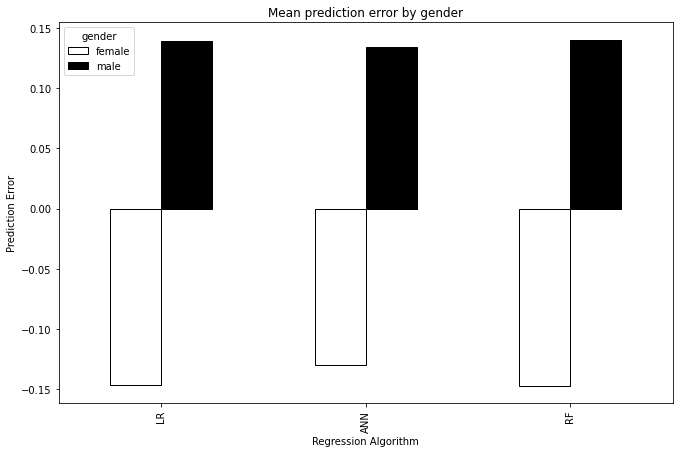

In [20]:
error_df = pd.DataFrame(A_test)
gender_map = {0: 'female',
              1: 'male'}
error_df['gender'] = error_df.gender.map(gender_map)
error_df['lr_pred'] = lr_pred - y_test
error_df['mlp_pred'] = mlp_pred - y_test
error_df['rf_pred'] = rf_pred - y_test
fig = error_df.groupby('gender').mean().rename(columns={'lr_pred':'LR',
                                                  'mlp_pred': 'ANN',
                                                  'rf_pred': 'RF'}
                                         ).T.plot(kind='bar',
                                                  figsize=(11,7),
                                                  title='Mean prediction error by gender',
                                                  colormap='binary',
                                                  linewidth=1,
                                                  edgecolor='black')
fig.set(xlabel="Regression Algorithm", ylabel="Prediction Error")

The user-selected definition of undesirable behavior corresponds to large differences in mean prediction errors (mean predicted GPA minus mean observed GPA) for applicants of **different genders**. 

This plot shows the mean prediction errors for male and female students when using each regression algorithm.

All shown standard ML methods tend to notably overpredict the performance of male students and underpredict the performance of female students

## Mean Squared Error and Accuracy Rate Using GridSearch and Exponentiated Gradient 

In [264]:
import random
from sklearn.preprocessing import MinMaxScaler
import sklearn.metrics as skm
from fairlearn.metrics import group_mean_prediction, group_mean_squared_error, group_mean_overprediction
import fairlearn.metrics as flm 

### Data Processing

In [265]:
def prob_decision(p):
    return 1*(random.random() < p)

In [266]:
min_max_scaler = MinMaxScaler()                                                  
y_train_rescaled = min_max_scaler.fit_transform(np.array(y_train).reshape(-1, 1))
y_test_rescaled = min_max_scaler.fit_transform(np.array(y_test).reshape(-1, 1))

In [267]:
#  set yi=0 with probability zi --> if zi > 0.5 then yi = 0 <-> if zi < 0.5 then yi = 1
y_train_scaled = pd.Series(y_train_rescaled.reshape(-1))
y_train_binary = y_train_scaled.apply(prob_decision)

### 1. Baseline: Logistic Regression Model without Fairness Constraints

In [300]:
unmitigated_predictor_rescaled = LogisticRegression(solver='liblinear', fit_intercept=True)
unmitigated_predictor_rescaled.fit(X_train, y_train_binary)
scores_unmitigated_rescaled = pd.Series(unmitigated_predictor_rescaled.predict_proba(X_test)[:,1], name="score_unmitigated_rescaled")


In [301]:
mse_unmitigated = group_metric_as_df("mse_unmitigated_rescaled", group_mean_squared_error(y_test_rescaled, scores_unmitigated_rescaled, A_test))
mse_unmitigated.rename(index={0: "female", 1: "male"}, inplace=True)
display(mse_unmitigated)

,mse_unmitigated_rescaled
female,0.034022
male,0.043226
overall,0.038719


In [302]:
mse_unmitigated_overprediction = group_metric_as_df("mse_unmitigated_overprediction", group_mean_overprediction(y_test_rescaled, scores_unmitigated_rescaled, A_test))
mse_unmitigated_overprediction.rename(index={0: "female", 1: "male"}, inplace=True)
display(mse_unmitigated_overprediction)

,mse_unmitigated_overprediction
female,0.060785
male,0.102072
overall,0.081855


In [303]:
mse_unmitigated_underprediction = group_metric_as_df("mse_unmitigated_underprediction", group_mean_underprediction(y_test_rescaled, scores_unmitigated_rescaled, A_test))
mse_unmitigated_underprediction.rename(index={0: "female", 1: "male"}, inplace=True)
display(mse_unmitigated_underprediction)

,mse_unmitigated_underprediction
female,0.088945
male,0.061822
overall,0.075103


### 2. GridSearch: Logistic Regression Model with Equalized Odds as Fairness Constraint 

In [272]:
sweep_gs_rescaled = GridSearch(LogisticRegression(solver='liblinear', fit_intercept=True),
                   constraints=EqualizedOdds(),
                   grid_size=50,
                   grid_limit=10)
sweep_gs_rescaled.fit(X_train, y_train_binary, sensitive_features=A_train)
best_results_gs_rescaled = sweep_gs_rescaled.predict_proba(X_test)

In [304]:
scores_best_gs_rescaled = pd.Series(best_results_gs_rescaled[:,1], name="score_best_gs_rescaled")

In [305]:
mse_gridsearch = group_metric_as_df("mse_gridsearch_eo", group_mean_squared_error(y_test_rescaled, scores_best_gs_rescaled, A_test))
mse_gridsearch.rename(index={0: "female", 1: "male"}, inplace=True)
display(mse_gridsearch)

,mse_gridsearch_eo
female,0.034022
male,0.043226
overall,0.038719


In [306]:
mse_gridsearch_overprediction = group_metric_as_df("mse_gridsearch_overprediction", group_mean_overprediction(y_test_rescaled, scores_best_dp_rescaled, A_test))
mse_gridsearch_overprediction.rename(index={0: "female", 1: "male"}, inplace=True)
display(mse_gridsearch_overprediction)

,mse_gridsearch_overprediction
female,0.060986
male,0.102777
overall,0.082313


In [422]:
mse_gridsearch_underprediction = group_metric_as_df("mse_gridsearch_underprediction", group_mean_underprediction(y_test_rescaled, scores_best_dp_rescaled, A_test))
mse_gridsearch_underprediction.rename(index={0: "female", 1: "male"}, inplace=True)
display(mse_gridsearch_underprediction)

,mse_gridsearch_underprediction
female,0.087966
male,0.061215
overall,0.074314


In [295]:
### TEST WITH DIFFERENT GRID SIZES
# sweep_gs_test = GridSearch(LogisticRegression(solver='liblinear', fit_intercept=True),
#                    constraints=EqualizedOdds(),
#                    grid_size=100,
#                    grid_limit=10)
# sweep_gs_test.fit(X_train, y_train_binary, sensitive_features=A_train)

### 3. Exponentiated Gradient: Logistic Regression Model with Equalized Odds as Fairness Constraint 

In [376]:
# EO without balanced dataset 

# tried: eps=0.01, 0.05 and nu 1e-6, 1e-5;
expgrad_eo = ExponentiatedGradient(
    LogisticRegression(solver='liblinear', fit_intercept=True),
    constraints=EqualizedOdds(),
    eps=0.01,
    nu=1e-6)
expgrad_eo.fit(
    X_train,
    y_train_binary,
    sensitive_features=A_train)

In [377]:
scores_expgrad_eo = pd.Series(expgrad_eo.predict(X_test), name="scores_expgrad_eo_rescaled")

In [378]:
for score in scores_expgrad_eo:
    if score!= 1:
        print(score)

In [379]:
mse_expgrad_overprediction = group_metric_as_df("mse_expgrad_eo_overprediction", group_mean_overprediction(y_test_rescaled, scores_expgrad_eo, A_test))
mse_expgrad_overprediction.rename(index={0: "female", 1: "male"}, inplace=True)
display(mse_expgrad_overprediction)

,mse_expgrad_eo_overprediction
female,0.257064
male,0.349142
overall,0.304055


In [380]:
mse_expgrad_underprediction = group_metric_as_df("mse_expgrad_eo_underprediction", group_mean_underprediction(y_test_rescaled, scores_expgrad_eo, A_test))
mse_expgrad_underprediction.rename(index={0: "female", 1: "male"}, inplace=True)
display(mse_expgrad_underprediction)

,mse_expgrad_eo_underprediction
female,-0.0
male,-0.0
overall,-0.0


In [329]:
# EO with balanced dataset 
balanced_index_pass0 = y_train_binary[y_train_binary==0].index 
balanced_index_pass1 = y_train_binary[y_train_binary==1].sample(n=balanced_index_pass0.size, random_state=0).index
balanced_index = balanced_index_pass0.union(balanced_index_pass1)

expgrad_eo_balanced = ExponentiatedGradient(
    LogisticRegression(solver='liblinear', fit_intercept=True),
    constraints=EqualizedOdds(),
    eps=0.01,
    nu=1e-6)

expgrad_eo_balanced.fit(
    X_train.iloc[balanced_index,:],
    y_train_binary.iloc[balanced_index],
    sensitive_features=A_train.iloc[balanced_index])

In [330]:
scores_expgrad_eo_balanced = pd.Series(expgrad_eo_balanced.predict(X_test), name="scores_expgrad_eo_balanced")

In [381]:
mse_expgrad_balanced_overprediction = group_metric_as_df("mse_expgrad_eo_balanced_overprediction", group_mean_overprediction(y_test_rescaled, scores_expgrad_eo_balanced, A_test))
mse_expgrad_balanced_overprediction.rename(index={0: "female", 1: "male"}, inplace=True)
display(mse_expgrad_balanced_overprediction)

,mse_expgrad_eo_balanced_overprediction
female,0.114763
male,0.144232
overall,0.129802


In [382]:
mse_expgrad_balanced_underprediction = group_metric_as_df("mse_expgrad_eo_balanced_underprediction", group_mean_underprediction(y_test_rescaled, scores_expgrad_eo_balanced, A_test))
mse_expgrad_balanced_underprediction.rename(index={0: "female", 1: "male"}, inplace=True)
display(mse_expgrad_balanced_underprediction)

,mse_expgrad_eo_balanced_underprediction
female,0.321505
male,0.298257
overall,0.309641


### Result Analysis: Baseline vs. GridSearch vs. Exponentiated Gradient

### MSE Overprediction and Underprediction 

#### Overall MSE Overprediction and Underprediction for Each Model

In [394]:
mse_overprediction = pd.concat([mse_unmitigated_overprediction, mse_gridsearch_overprediction, mse_expgrad_overprediction, mse_expgrad_balanced_overprediction], axis = 1)
mse_underprediction = pd.concat([mse_unmitigated_underprediction, mse_gridsearch_underprediction, mse_expgrad_underprediction, mse_expgrad_balanced_underprediction], axis = 1)

In [395]:
display(mse_overprediction, mse_underprediction)

,mse_unmitigated_overprediction,mse_gridsearch_overprediction,mse_expgrad_eo_overprediction,mse_expgrad_eo_balanced_overprediction
female,0.060785,0.060986,0.257064,0.114763
male,0.102072,0.102777,0.349142,0.144232
overall,0.081855,0.082313,0.304055,0.129802


,mse_unmitigated_underprediction,mse_gridsearch_underprediction,mse_expgrad_eo_underprediction,mse_expgrad_eo_balanced_underprediction
female,0.088945,0.087966,-0.0,0.321505
male,0.061822,0.061215,-0.0,0.298257
overall,0.075103,0.074314,-0.0,0.309641


In [439]:
mse_concat = pd.concat([mse_overprediction, mse_underprediction], axis=1)
mse_concat.reset_index()

,index,mse_unmitigated_overprediction,mse_gridsearch_overprediction,mse_expgrad_eo_overprediction,mse_expgrad_eo_balanced_overprediction,mse_unmitigated_underprediction,mse_gridsearch_underprediction,mse_expgrad_eo_underprediction,mse_expgrad_eo_balanced_underprediction
0,female,0.060785,0.060986,0.257064,0.114763,0.088945,0.087966,-0.0,0.321505
1,male,0.102072,0.102777,0.349142,0.144232,0.061822,0.061215,-0.0,0.298257
2,overall,0.081855,0.082313,0.304055,0.129802,0.075103,0.074314,-0.0,0.309641


[Text(17.200000000000003, 0.5, 'Mean Squared Error'),
 Text(0.5, 17.200000000000003, 'Model Type')]

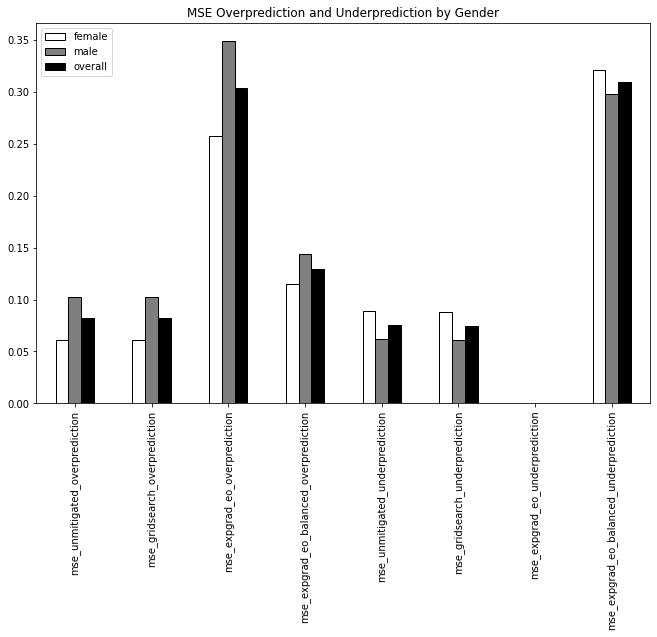

In [442]:
mse_concat.groupby(level=0).mean().T.plot(kind='bar',
                                                  figsize=(11,7),
                                                  title='MSE Overprediction and Underprediction by Gender',
                                                  colormap='binary',
                                                  linewidth=1,
                                                  edgecolor='black')
fig.set(xlabel="Model Type", ylabel="Mean Squared Error")

#### Difference in MSE Overprediction between the Different Groups 
Calculating the percentage difference in MSE overprediction for each gender relative to the "overall" MSE overprediction 

In [452]:
mse_overprediction_diff_female = np.round((mse_overprediction.loc["female"] - mse_overprediction.loc["overall"]) / mse_overprediction.loc["overall"] * 100 , 2)
mse_overprediction_diff_male = np.round((mse_overprediction.loc["male"] - mse_overprediction.loc["overall"]) / mse_overprediction.loc["overall"] * 100, 2)
mse_overprediction_diff = pd.concat([mse_overprediction_diff_female, mse_overprediction_diff_male], axis=1)
mse_overprediction_diff.rename(columns={0:"female", 1:"male"}, inplace=True )

In [453]:
mse_underprediction_diff_female = np.round((mse_underprediction.loc["female"] - mse_underprediction.loc["overall"]) / mse_underprediction.loc["overall"] * 100 , 2)
mse_underprediction_diff_male = np.round((mse_underprediction.loc["male"] - mse_underprediction.loc["overall"]) / mse_underprediction.loc["overall"] * 100, 2)
mse_underprediction_diff = pd.concat([mse_underprediction_diff_female, mse_underprediction_diff_male], axis=1)
mse_underprediction_diff.rename(columns={0:"female", 1:"male"}, inplace=True )

In [454]:
display(mse_overprediction_diff)
display(mse_underprediction_diff)

,female,male
mse_unmitigated_overprediction,-25.74,24.70
mse_gridsearch_overprediction,-25.91,24.86
mse_expgrad_eo_overprediction,-15.45,14.83
mse_expgrad_eo_balanced_overprediction,-11.59,11.12


,female,male
mse_unmitigated_underprediction,18.43,-17.68
mse_gridsearch_underprediction,18.37,-17.63
mse_expgrad_eo_underprediction,NaN,NaN
mse_expgrad_eo_balanced_underprediction,3.83,-3.68


In [507]:
mse_diff_concat = pd.concat([mse_overprediction_diff, mse_underprediction_diff])
# mse_diff_concat.reset_index(inplace=True)

In [493]:
mse_diff_concat = pd.concat([mse_overprediction_diff, mse_underprediction_diff])
mse_diff_concat.reset_index(inplace=True)
mse_diff_concat.set_index(["female", "male"], inplace=True)

[Text(17.200000000000003, 0.5, 'Mean Squared Error'),
 Text(0.5, 17.200000000000003, 'Model Type')]

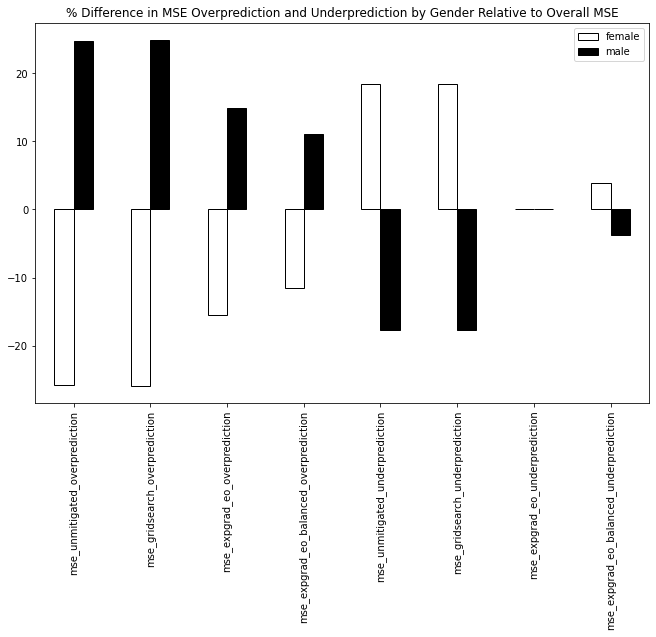

In [514]:
mse_diff_concat.T.groupby(level=0).mean().T.plot(kind='bar',
                                                  figsize=(11,7),
                                                  title='% Difference in MSE Overprediction and Underprediction by Gender Relative to Overall MSE',
                                                  colormap='binary',
                                                  linewidth=1,
                                                  edgecolor='black')
fig.set(xlabel="Model Type", ylabel="Mean Squared Error")

In [537]:
A_test_renamed = A_test.replace([0,1], ["female", "male"])

In [539]:
from fairlearn.widget import FairlearnDashboard

FairlearnDashboard(sensitive_features=A_test_renamed, 
                   y_true=y_test,
                   y_pred={"unmitigated": scores_unmitigated_rescaled,
                           "gridsearch": scores_best_gs_rescaled, 
                           "expgrad_balanced": scores_expgrad_eo_balanced
                   })

FairlearnWidget(value={'true_y': [2.01, 3.39333, 3.03667, 3.35, 3.89, 2.94667, 1.88333, 3.5466699999999998, 2.…

## Replicating Fig. 3 in "Preventing undesirable behavior of intelligent machines" 

In attempt to replicate fig. 3 in ["Preventing undesirable behavior of intelligent machines" (Thomas et. al 2019) ](https://science.sciencemag.org/content/366/6468/999), we further explored the effects of using Grid Search and Exponentiated Gradient methods to impose Fairlearn's Demographic Parity and Equalized Odds fairness constraints on the GPA classification algorithm results.

First, we train a standard logistic regression predictor that does not seek to incorporate any notion of fairness. We simply fit this Logistic Regression model to the training data and plot some characteristics of training and test data as well as the predictions of the model on those datasets. 

In [22]:
unmitigated_predictor = LogisticRegression(solver='liblinear', fit_intercept=True)
unmitigated_predictor.fit(X_train, y_train_bool)
predict_unmitigated = unmitigated_predictor.predict(X_test)
scores_unmitigated = pd.Series(unmitigated_predictor.predict_proba(X_test)[:,1], name="score_unmitigated")

In [23]:
A_test_renamed = A_test.replace({0: "female", 1: "male"})

We interpret the probabilistic predictions outputted by the logistic regression as the scores and evaluate the quality of the GPA classification they produce in terms of the prediction accuracy. We decided to use accuracy as our performance metrics because the dataset is relatively balanced between the two groups, i.e. female and male students.

Before we continue with our analysis, we will provide the definition of the metric used. The accuracy score is, informally, defined as the fraction of predictions our model gets right and formally, defined as the number of correct predictions (TP+TN) divided by total predictions (TP+TN+FP+FN). Although the logistic regression estimator is designed to directly optimize the logistic loss not the accuracy score, a good logistic loss is still expected to give a good accuracy score.

To obtain the accuracy values for the overall student population as well as black and white subpopulations, we use the group metric variant of the sklearn metric accuracy_score.

In [24]:
acc_unmitigated = group_metric_as_df("accuracy_unmitigated",
                                     group_accuracy_score(y_test_bool, predict_unmitigated, A_test))
acc_unmitigated.rename(index={0: "female", 1: "male"}, inplace=True)
display(acc_unmitigated)

,accuracy_unmitigated
female,0.609290
male,0.673982
overall,0.642305



original test data:


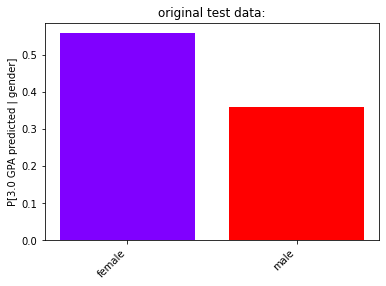

In [25]:
show_proportions(X_test, A_test_renamed, y_test_bool, description="original test data:", plot_row_index=3)
plt.show()


fairness-unaware prediction on test data:


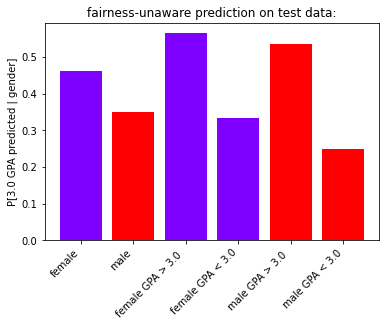

In [26]:
show_proportions(X_test, A_test_renamed, predict_unmitigated, y_test_bool, description="fairness-unaware prediction on test data:", plot_row_index=4)
plt.show()

We notice that males have approx. 1-2% higher likelihood of getting a predicted GPA above 3.0 whereas women have about 10% lower likelihood of getting assigned a predicted GPA above 3.0.

We will now use Fairlearn's Grid Search and Exponentiated Gradient algorithms to impose fairness constraints on the ML algorithms. The goal is to make the output fair with respect to fairness constraints. \\
The Fairlearn algorithms use one of the following fairness constraints:  
- Demographic Parity (DP): $P\ [\ h(X)=\hat{y}\ |\ A=a] = P\ [\ h(X)=\hat{y}\ ] \qquad \forall a, \hat{y}$
- Equalized Odds (EO): $P\ [\ h(X)=\hat{y}\ |\ A=a, Y=y] = P\ [\ h(X)=\hat{y}\ |\ Y=y\ ] \qquad \forall a, \hat{y}$

where $h(X)$ is the prediction based on the input $X$, $\hat{y}$ and $y$ are labels, and $a$ is a sensitive feature value. \\





#### Mitigating Demographic Disparity with Grid Search 

We will now use Fairlearn's Grid Search algorithm to mitigate the demographic disparity by building models that achieve various trade-offs between accuracy and demographic disparity.

GridSearch generates models corresponding to various Lagrange multiplier vectors of the underlying constraint optimization problem. We will compute 50 models on a grid of Lagrange multiplier vectors whose L1-norm is bounded by 10. For details on how the search works, refer to Section 3.4 of Agarwal et. al (2018). 


##### Using Demographic Parity as Fairness Constraint

In [ ]:
first_sweep_dp = GridSearch(LogisticRegression(solver='liblinear', fit_intercept=True),
                   constraints=DemographicParity(),
                   grid_size=50,
                   grid_limit=10)
first_sweep_dp.fit(X_train, y_train_bool, sensitive_features=A_train)
Y_first_predict_dp = first_sweep_dp.predict(X_test)
best_results_dp_proba = first_sweep_dp.predict_proba(X_test)
scores_best_dp = pd.Series(best_results_dp_proba[:,1], name="score_best_model")

In [0]:
acc_gs_dp = group_metric_as_df("accuracy_gs_dp",
                                     group_accuracy_score(y_test_bool, Y_first_predict_dp, A_test_renamed))

In [0]:
lambda_vecs_dp = first_sweep_dp._lambda_vecs
actual_multipliers_dp = [lambda_vecs_dp[col][("+", "all", 1)]-lambda_vecs_dp[col][("-", "all", 1)] for col in lambda_vecs_dp]

In [0]:
first_sweep_sensitive_feature_weights_dp = [
            predictor.coef_[0][1] for predictor in first_sweep_dp._predictors]
# plt.scatter(actual_multipliers_dp, first_sweep_sensitive_feature_weights_dp)
# plt.xlabel("Lagrange Multiplier for GS with Demographic Parity")
# plt.ylabel("Weight of Protected Attribute in Model")
# plt.show()

In [0]:
lambda_best_dp = first_sweep_dp._lambda_vecs[first_sweep_dp._best_grid_index][("+", "all", 1)] - first_sweep_dp._lambda_vecs[first_sweep_dp._best_grid_index][("-", "all", 1)]
# print("lambda_best_dp =", lambda_best_dp)
# print("coefficients_dp =", first_sweep_dp._predictors[first_sweep_dp._best_grid_index].coef_)

#### Using Equalized Odds

In [0]:
first_sweep_eo =  GridSearch(LogisticRegression(solver='liblinear', fit_intercept=True),
                   constraints=EqualizedOdds(),
                   grid_size=50,
                   grid_limit=10)
first_sweep_eo.fit(X_train, y_train_bool, sensitive_features=A_train)
Y_first_predict_eo = first_sweep_eo.predict(X_test)
best_results_eo_proba = first_sweep_eo.predict_proba(X_test)
scores_best_eo = pd.Series(best_results_eo_proba[:,1], name="score_best_model")

In [0]:
acc_gs_eo = group_metric_as_df("accuracy_gs_eo",
                                     group_accuracy_score(y_test_bool, Y_first_predict_eo, A_test_renamed))

In [0]:
acc_agg_gs = pd.concat([acc_unmitigated, acc_gs_dp, acc_gs_eo], axis=1)
display(acc_agg_gs)

,accuracy_unmitigated,accuracy_gs_dp,accuracy_gs_eo
female,0.609526,0.599623,0.609526
male,0.673982,0.655430,0.673982
overall,0.642420,0.628103,0.642420


#### Mitigating Demographic Disparity with Exponentiated Gradient 

ExponentiatedGradient also seeks to find a classifier that optimizes accuracy while placing a constraint on the demographic disparity. It operates as a reduction to standard classification, taking any estimator as a black box. During its run it repeatedly re-fits the estimator on variously reweighted training data and eventually produces a randomized classifier of the same type as the provided black-box estimator. This means that if the black box does not have access to the sensitive feature, neither will the predictor fitted by ExponentiatedGradient.


We train two classifiers via ExponentiatedGradient. Both use LogisticRegression as a black box. However, one has only access to the original features (X_train and X_test), whereas the other one also has access to the sensitive features, which we include in the extended feature set (XA_train and XA_test). Both classifiers optimize accuracy subject to the constraint that demographic disparity on training data is at most 0.01. We also set the convergence parameter nu to 1e-6 to optimize to numerical precision (the default is to optimize to statistical precision, which we override here).

In [0]:
balanced_index_pass0 = y_train_bool[y_train==0].index 
balanced_index_pass1 = y_train_bool[y_train_bool==1].sample(n=balanced_index_pass0.size, random_state=0).index
balanced_index = balanced_index_pass0.union(balanced_index_pass1)

In [0]:
XA_train = pd.concat([X_train, A_train==0], axis=1).astype(float)
XA_test = pd.concat([X_test, A_test==0], axis=1).astype(float)


##### Using Demographic Parity as Fairness Constraint




In [0]:
expgrad_dp_X= ExponentiatedGradient(
    LogisticRegression(solver='liblinear', fit_intercept=True),
    constraints=DemographicParity(),
    eps=0.01,
    nu=1e-6)
expgrad_dp_XA = ExponentiatedGradient(
    LogisticRegression(solver='liblinear', fit_intercept=True),
    constraints=DemographicParity(),
    eps=0.01,
    nu=1e-6)

expgrad_dp_X.fit(
    X_train.iloc[balanced_index,:],
    y_train.iloc[balanced_index],
    sensitive_features=A_train.iloc[balanced_index])
expgrad_dp_XA.fit(
    XA_train.iloc[balanced_index,:],
    y_train.iloc[balanced_index],
    sensitive_features=A_train.iloc[balanced_index])

In [0]:
scores_expgrad_dp_X = pd.Series(expgrad_dp_X.predict(X_test), name="scores_dp_expgrad_X")
scores_expgrad_dp_XA = pd.Series(expgrad_dp_XA.predict(XA_test), name="scores_dp_expgrad_XA")

acc_expgrad_dp_X = group_metric_as_df(
    "accuracy_expgrad_dp_X",
    group_roc_auc_score(y_test_bool, scores_expgrad_dp_X, A_test_renamed))
acc_expgrad_dp_XA = group_metric_as_df(
    "accuracy_expgrad_dp_XA",
    group_roc_auc_score(y_test_bool, scores_expgrad_dp_XA, A_test_renamed))

#### Using Equalized Odds

In [0]:
expgrad_eo_X= ExponentiatedGradient(
    LogisticRegression(solver='liblinear', fit_intercept=True),
    constraints=EqualizedOdds(),
    eps=0.01,
    nu=1e-6)
expgrad_eo_XA = ExponentiatedGradient(
    LogisticRegression(solver='liblinear', fit_intercept=True),
    constraints=EqualizedOdds(),
    eps=0.01,
    nu=1e-6)

expgrad_eo_X.fit(
    X_train.iloc[balanced_index,:],
    y_train.iloc[balanced_index],
    sensitive_features=A_train.iloc[balanced_index])
expgrad_eo_XA.fit(
    XA_train.iloc[balanced_index,:],
    y_train.iloc[balanced_index],
    sensitive_features=A_train.iloc[balanced_index])

In [0]:
scores_expgrad_eo_X = pd.Series(expgrad_eo_X.predict(X_test), name="scores_eo_expgrad_X")
scores_expgrad_eo_XA = pd.Series(expgrad_eo_XA.predict(XA_test), name="scores_eo_expgrad_XA")

acc_expgrad_eo_X = group_metric_as_df(
    "accuracy_expgrad_eo_X",
    group_roc_auc_score(y_test_bool, scores_expgrad_eo_X, A_test_renamed))
acc_expgrad_eo_XA = group_metric_as_df(
    "accuracy_expgrad_eo_XA",
    group_roc_auc_score(y_test_bool, scores_expgrad_eo_XA, A_test_renamed))

In [0]:
acc_agg_expgrad = pd.concat([acc_unmitigated, acc_expgrad_dp_X, acc_expgrad_dp_XA, acc_expgrad_eo_X, acc_expgrad_eo_XA], axis=1)

In [0]:
display(acc_agg_expgrad)

,accuracy_unmitigated,accuracy_expgrad_dp_X,accuracy_expgrad_dp_XA,accuracy_expgrad_eo_X,accuracy_expgrad_eo_XA
female,0.609526,0.492725,0.499919,0.501277,0.505268
male,0.673982,0.504730,0.502945,0.505434,0.497978
overall,0.642420,0.495826,0.495892,0.504496,0.502181


# BGL Regression

We apply bounded group loss to linear regression using Grid Search as defined in ["Fair Regression: Quantitative Definitions and Reduction-based Algorithms" (Agarwal et al. 2019)](https://arxiv.org/abs/1905.12843). 

Bounded group loss requires that a predictor's loss remains below a specified level for each protected group. BGL minimizes the overall loss, while controlling the loss on a protected group (max-min fairness).

It is important to note BGL does not enforce an artificial decrease in performance to match the hardest to predict. 

We apply BGL on the exam data with gender as our protected attribute. We saw in unmitigated linear regression that our prediction over-predicted male GPA and under-predicted female. 

In [0]:
bgl_square_loss = GroupLossMoment(SquareLoss(-np.inf, np.inf))
grid_search = GridSearch(LinearRegression(),
                             constraints=bgl_square_loss,
                             grid_size=41)
grid_search.fit(X_train, y_train, sensitive_features=A_train)
best_predict = grid_search.predict(X_test)

In [0]:
lambda_vecs_regression = grid_search._lambda_vecs
# print(lambda_vecs_regression)
actual_multipliers_regression = lambda_vecs_regression.loc[1]
actual_multipliers_regression_female = lambda_vecs_regression.loc[0]
print(grid_search._best_grid_index)

losses = [loss_fct(i) for i in range(len(grid_search._objectives))]


30


We run grid search using Bounded Group loss. We see that the best grid index occurs when the lagrange multiplier value of 1.5 for males and 0.5 for females.  

In [0]:
mse_bgl = group_metric_as_df(
      "MSE BGL", 
      group_mean_squared_error(y_test, best_predict, A_test))
mse_lr = group_metric_as_df(
      "MSE LR", 
      group_mean_squared_error(y_test, lr_pred, A_test))
disp_bgl = group_metric_as_df(
    "Disparity BGL",
    group_mean_prediction(y_test, best_predict, A_test))
disp_lr = group_metric_as_df(
    "Disparity LR",
    group_mean_prediction(y_test, lr_pred, A_test))

over_pred_bgl = group_metric_as_df(
    "overpred BGL",
    group_mean_overprediction(y_test, best_predict, A_test))
over_pred_unmit = group_metric_as_df(
    "overpred LR",
    group_mean_overprediction(y_test, lr_pred, A_test))

bgl_summary_regression = pd.concat([mse_lr, mse_bgl, disp_lr, disp_bgl, over_pred_unmit, over_pred_bgl], axis=1)
bgl_summary_regression.loc['disparity']=(bgl_summary_regression.loc[0]-bgl_summary_regression.loc[1]).abs()
bgl_summary_regression.loc['disparity', bgl_summary_regression.columns.str.startswith('mse')]='-'
bgl_summary_regression.loc['disparity', bgl_summary_regression.columns.str.startswith('overpred')]='-'
bgl_summary_regression.rename(index={0: "female", 1: "male"}, inplace=True)
display(bgl_summary_regression)

,MSE LR,MSE BGL,Disparity LR,Disparity BGL,overpred LR,overpred BGL
female,0.523292,0.551448,2.825363,2.750747,0.215446,0.189399
male,0.644119,0.628346,2.742930,2.679851,0.381711,0.348775
overall,0.584954,0.590692,2.783295,2.714566,0.300296,0.270734
disparity,0.120826,0.076898,0.082434,0.070897,-,-


We see that the MSE of the BGL regression is higher for both male and female compared to unmitigated regression. We see that the disparity between the two groups is smaller in BGL. 

We do see that the overprediction of males decreases in BGL. This is good as we saw that our unmitigated regressor overpredicted male GPA. 

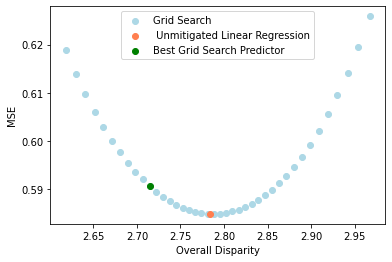

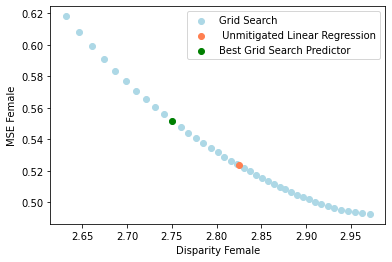

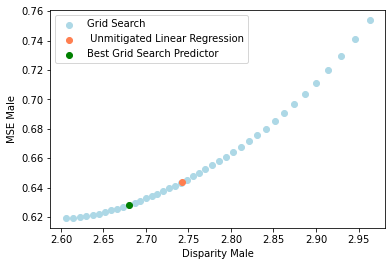

In [0]:
y_preds_bgl = [grid_search._predictors[i].predict(X_test) for i in range(len(grid_search._predictors))]


mse_bgl_groups = [group_metric_as_df(i, group_mean_squared_error(y_test, y_preds_bgl[i], A_test)) for i in range(len(y_preds_bgl))]
disp_bgl_groups = [group_metric_as_df(i, group_mean_prediction(y_test, y_preds_bgl[i], A_test)) for i in range(len(y_preds_bgl))]
overpred_bgl_groups = [group_metric_as_df(i, group_mean_overprediction(y_test, y_preds_bgl[i], A_test)) for i in range(len(y_preds_bgl))]

bgl_df_mse = pd.concat(mse_bgl_groups, axis = 1)
bgl_df_disp = pd.concat(disp_bgl_groups, axis = 1)
bgl_df_overpred = pd.concat(overpred_bgl_groups, axis = 1)


plt.scatter(bgl_df_disp.loc['overall'], bgl_df_mse.loc['overall'], c = 'lightblue', label='Grid Search')
plt.scatter(disp_lr.loc['overall'], mse_lr.loc['overall'], c = 'coral', label = ' Unmitigated Linear Regression')
plt.scatter(disp_bgl.loc['overall'], mse_bgl.loc['overall'], c = 'green', label = 'Best Grid Search Predictor')
plt.xlabel("Overall Disparity")
plt.ylabel("MSE")
plt.legend()
plt.show()



plt.scatter(bgl_df_disp.loc[0], bgl_df_mse.loc[0], c = 'lightblue', label='Grid Search')
plt.scatter(disp_lr.loc[0], mse_lr.loc[0], c = 'coral', label = ' Unmitigated Linear Regression')
plt.scatter(disp_bgl.loc[0], mse_bgl.loc[0], c = 'green', label = 'Best Grid Search Predictor')
plt.xlabel("Disparity Female")
plt.ylabel("MSE Female")
plt.legend()
plt.show()

plt.scatter(bgl_df_disp.loc[1], bgl_df_mse.loc[1], c = 'lightblue', label='Grid Search')
plt.scatter(disp_lr.loc[1], mse_lr.loc[1], c = 'coral', label = ' Unmitigated Linear Regression')
plt.scatter(disp_bgl.loc[1], mse_bgl.loc[1], c = 'green', label = 'Best Grid Search Predictor')
plt.xlabel("Disparity Male")
plt.ylabel("MSE Male")
plt.legend()
plt.show()




We see that the MSE is smallest on the unmitigated linear regression. However, BGL in Grid Search selects a model that has a slightly higher MSE. However, the overall disparity between male and female is lower in the chosen model. 

With BGL we want to minimize the overall loss on the model while ensuring each protected groups' loss is bounded within a certain level. 



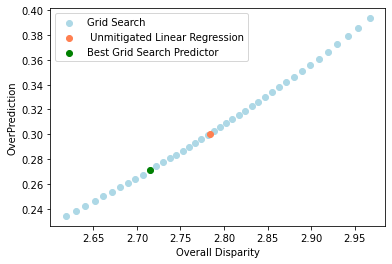

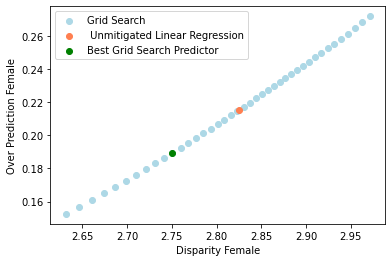

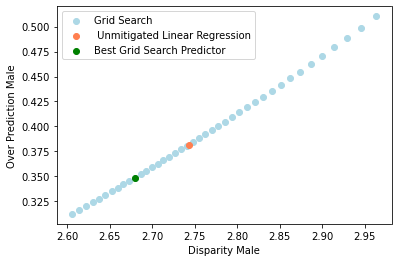

In [0]:
plt.scatter(bgl_df_disp.loc['overall'], bgl_df_overpred.loc['overall'], c = 'lightblue', label='Grid Search')
plt.scatter(disp_lr.loc['overall'], over_pred_unmit.loc['overall'], c = 'coral', label = ' Unmitigated Linear Regression')
plt.scatter(disp_bgl.loc['overall'], over_pred_bgl.loc['overall'], c = 'green', label = 'Best Grid Search Predictor')
plt.xlabel("Overall Disparity")
plt.ylabel("OverPrediction")
plt.legend()
plt.show()



plt.scatter(bgl_df_disp.loc[0], bgl_df_overpred.loc[0], c = 'lightblue', label='Grid Search')
plt.scatter(disp_lr.loc[0], over_pred_unmit.loc[0], c = 'coral', label = ' Unmitigated Linear Regression')
plt.scatter(disp_bgl.loc[0], over_pred_bgl.loc[0], c = 'green', label = 'Best Grid Search Predictor')
plt.xlabel("Disparity Female")
plt.ylabel("Over Prediction Female")
plt.legend()
plt.show()

plt.scatter(bgl_df_disp.loc[1], bgl_df_overpred.loc[1], c = 'lightblue', label='Grid Search')
plt.scatter(disp_lr.loc[1], over_pred_unmit.loc[1], c = 'coral', label = ' Unmitigated Linear Regression')
plt.scatter(disp_bgl.loc[1], over_pred_bgl.loc[1], c = 'green', label = 'Best Grid Search Predictor')
plt.xlabel("Disparity Male")
plt.ylabel("Over Prediction Male")
plt.legend()
plt.show()

Furthermore, BGL selects a model that minimizes both the overall disparity as well as the overprediction rate. In the unmitigated linear regression, we saw that male students were over-predicted and female students were under-predicted. BGL lowers the overprediction for both male and female as well as the disparity between the two. However, since females naturally have a higher GPA we are still undercounting female performance in this new model. 

# Future Work 

In the next half of the quarter, we are going to work on implementing BGL for Exponentiated Gradient. To do so requires some re-configuring of the current code base. 


**Incorporating Right Hand Side to Gamma**

Most of the code was written with the original goal of classification. As we move towards regression, we need to make some structural changes. In classification, we have two parameters self.gamma and self.eps within the lagrangian. The gamma comes from the [moments](https://github.com/fairlearn/fairlearn/tree/master/fairlearn/reductions/_moments) classes in the repo. Our first task is to incorporate epsilon into the moments class for the different moments available. We will create a new parameter in the moments and a new method bound. Depending on the moment, the bound will be created by parameters passed into the constructor for the moment. The bound method will return a vector of epsilon values representing the bound. When we call the oracle we will be calling

   *L = error + np.sum(lambda_vec * (gamma - bound))*
 
 as opposed to
 
  *L = error + np.sum(lambda_vec * (gamma - self.eps))*

**Adding Control Flow to Lagrangian to Allow for Classification and Regression**

After incorporating the right hand side of gamma into the moments, we can update the lagrangian. BGL in exponentiated gradient uses a different call to the oracle than classification. Whereas the currently implemented use cases implement a cost-senstivive classification, BGL frames the problem as a risk minimization optimization problem. We need to update the current lagrangian to handle both regression and classification. The main changes will be within the [_call_oracle ](https://github.com/fairlearn/fairlearn/blob/master/fairlearn/reductions/_exponentiated_gradient/_lagrangian.py)method. Unlike in classification, we do not update the classes of Y in our optimization. We will add a control flow to the lagrangian to detect classification vs. regression reductions and apply correct oracle to solve the optimization.   

**Testing Implementation works as desired**

As we make these changes we not only need to test that the new code is compatible with the current infrastructure, but we also need to test that the BGL in Exponentiated Gradient works as desired. We will thoroughly test our implementation to ensure it works correctly. 


# Further Clarifications 